In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.colors as mcolors
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [89]:
np.random.seed(42)

In [90]:
dados = pd.read_csv("../src/dados_completos.csv")

Inicialmente eu vou pegar os dados e fazer a média de cada mês por cidade, então teremos os dados na seguinte disposição:

\begin{array}{|l|c|c|c|c|c|}
\hline
\text{Cidade} & 01 & 02 & 03 & \cdots & 12 \\
\hline
\text{Abreu e Lima} & 7.61 & 10.58 & 9.12 & \cdots & 8.95 \\
\text{Afogados...} & 5.23 & 6.89 & 7.45 & \cdots & 4.12 \\
\hline
\end{array}

In [91]:
# Criar features mensais médias para cada cidade
monthly_avg = dados.groupby(['Cidade', dados['Data'].str.split('-').str[1]])['Precipitacao_mm_mes'].mean().unstack()
monthly_avg.columns = [f'Precip_Media_Mes_{i+1:02d}' for i in range(12)]

Abaixo eu vou pegar as informações de Latitude, Logitude e Mesorregião de cada cidade e em seguinte vou agrupar, 
então os dados vão ficar com a seguinte diposição:
\begin{array}{|c|c|c|c|c|c|c|c|c|}
\hline
\text{Cidade} & \text{01} & \text{02} & \text{03} & \cdots & \text{12} & \text{Latitude} & \text{Longitude} & \text{Mesorregião} \\
\hline
\text{Abreu e Lima} & 7.61 & 10.58 & 9.12 & \cdots & 8.95 & -7.9116 & 34.90 & \text{Metropolitana do Recife} \\
\hline
\text{Afogados...} & 5.23 & 6.89 & 7.45 & \cdots & 4.12 & -7.75 & 37.64 & \text{Sertão Pernambucano} \\
\hline
\end{array}

In [92]:
# Adicionar informações geográficas
cidades_info = dados.groupby('Cidade')[['Latitude', 'Longitude', 'Mesorregião']].first()
dados_agregados = monthly_avg.merge(cidades_info, left_index=True, right_index=True)

Estou preparando dados para um modelo de Naive Bayes (classificador). O Naive Bayes precisa de uma variável target (alvo) que são as classes a serem previstas

In [93]:
dados_agregados['Target'] = dados_agregados['Mesorregião']

Primeiro cria uma lista com a precipitação dos 12 meses do ano.

* X representa a matriz de features (variáveis independentes)

* y representa o vetor de labels/classes (mesorregiões)

Depois Normaliza os dados

In [94]:
# Preparar features e target
features = [f'Precip_Media_Mes_{i+1:02d}' for i in range(12)]
X = dados_agregados[features]
y = dados_agregados['Target']

# Normalizar os dados (importante para GaussianNB)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

A seguir fazemos a divisão de train e test, escolhi 30% para fazer o teste o 70% para treinar

In [95]:
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

Eu quero encontrar o melhor valor de K (número de clsuteres). Eu vou tentar valores entre 1 e 21 clusteres e vou  ver qual deles tem uma melhor pontuação

In [96]:
k_range = range(1, 21)
k_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_knn, y_train_knn, cv=5, scoring='accuracy')
    k_scores.append(scores.mean())
    
best_k = k_range[np.argmax(k_scores)]
print(f"Melhor valor de K: {best_k} com acurácia: {max(k_scores):.3f}")

Melhor valor de K: 2 com acurácia: 0.628


Eu fiz um hráfico para mostrar os scores e o número de clsuteres trabalhados

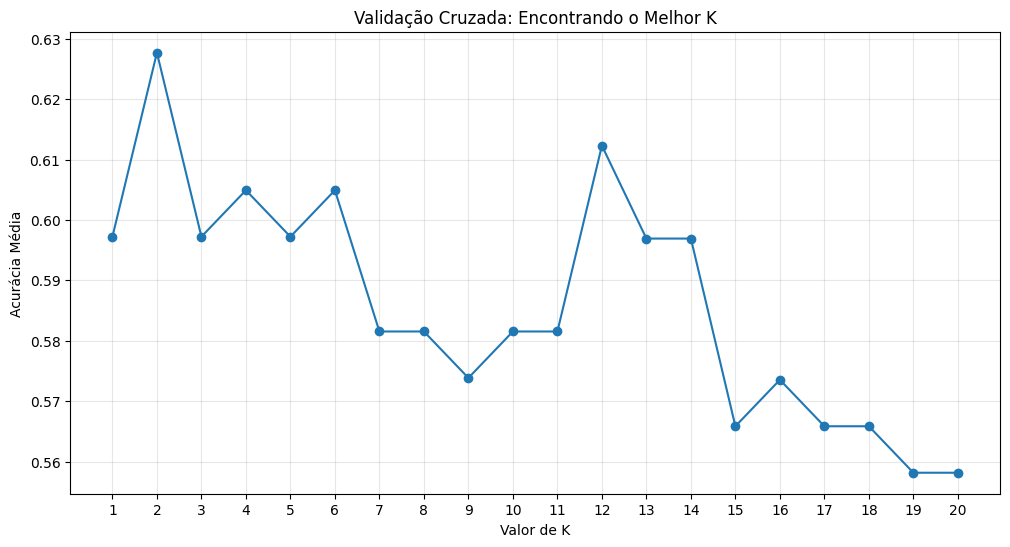

In [97]:
plt.figure(figsize=(12, 6))
plt.plot(k_range, k_scores, marker='o')
plt.title('Validação Cruzada: Encontrando o Melhor K')
plt.xlabel('Valor de K')
plt.ylabel('Acurácia Média')
plt.grid(True, alpha=0.3)
plt.xticks(k_range)
plt.show()

Primeiro eu criei uma "máquina de classificação" vazia com o K ideal e depois indiquei as variáveis de treinamento

In [98]:
modelo_knn = KNeighborsClassifier(n_neighbors=best_k)
modelo_knn.fit(X_train_knn, y_train_knn)

KNeighborsClassifier(n_neighbors=2)

Faço as previsões

In [99]:
y_pred_knn = modelo_knn.predict(X_test_knn)
y_pred_proba_knn = modelo_knn.predict_proba(X_test_knn)

* A acurácia mede a porcentagem de cidades classificadas corretamente
* Depois vejo a quais das cidades que o modelo classifcou como Sertão quantas são realemnte são Sertão

In [100]:
print("\n=== AVALIAÇÃO DO K-NN ===")
print(f"Acurácia: {accuracy_score(y_test_knn, y_pred_knn):.2%}")

print("\n=== RELATÓRIO DE CLASSIFICAÇÃO ===")
print(classification_report(y_test_knn, y_pred_knn))


=== AVALIAÇÃO DO K-NN ===
Acurácia: 62.50%

=== RELATÓRIO DE CLASSIFICAÇÃO ===
                            precision    recall  f1-score   support

      Agreste Pernambucano       0.58      1.00      0.74        21
         Mata Pernambucana       1.00      0.15      0.27        13
   Metropolitana do Recife       1.00      0.20      0.33         5
       Sertão Pernambucano       0.67      0.83      0.74        12
São Francisco Pernambucano       0.50      0.20      0.29         5

                  accuracy                           0.62        56
                 macro avg       0.75      0.48      0.47        56
              weighted avg       0.73      0.62      0.55        56



* Acurácia: 62.50% significa que o modelo acertou cerca de 2/3 das classificações
* O agreste atrai muitas classificações de outras regiões
* A região da mata e metropolitana tem padrões muito específicos que o K-NN não consegue capturar bem
* O K-NN conseguiu encontrar um padrão mais claro para o Sertão

Fiz uma matrix de confusão para entender como o modelo está funcionando. Indica o resultado  que tivemos no bloco anterior

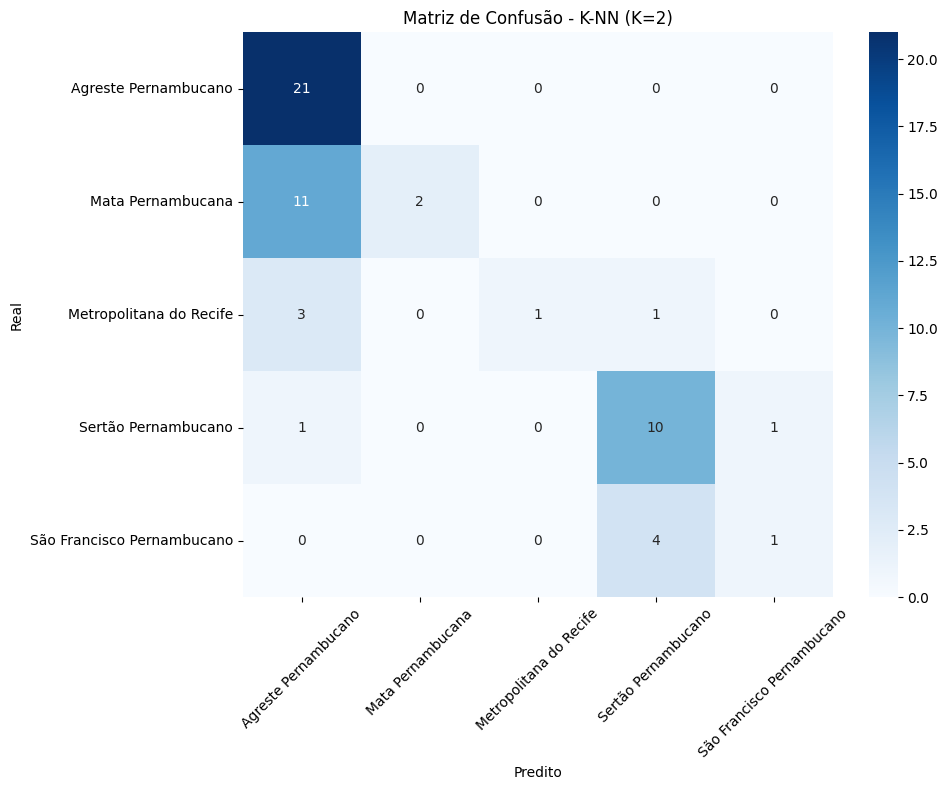

In [101]:
plt.figure(figsize=(10, 8))
cm_knn = confusion_matrix(y_test_knn, y_pred_knn)
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', 
            xticklabels=modelo_knn.classes_, 
            yticklabels=modelo_knn.classes_)
plt.title(f'Matriz de Confusão - K-NN (K={best_k})')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Usei o modelo para todas as cidades

In [102]:
X_all_scaled = scaler.transform(X)
y_pred_all_knn = modelo_knn.predict(X_all_scaled)
y_pred_proba_all_knn = modelo_knn.predict_proba(X_all_scaled)

Adicioneu as informações no dataframe

In [103]:
dados_agregados['Predicao_KNN'] = y_pred_all_knn
dados_agregados['Confiança_KNN'] = np.max(y_pred_proba_all_knn, axis=1)

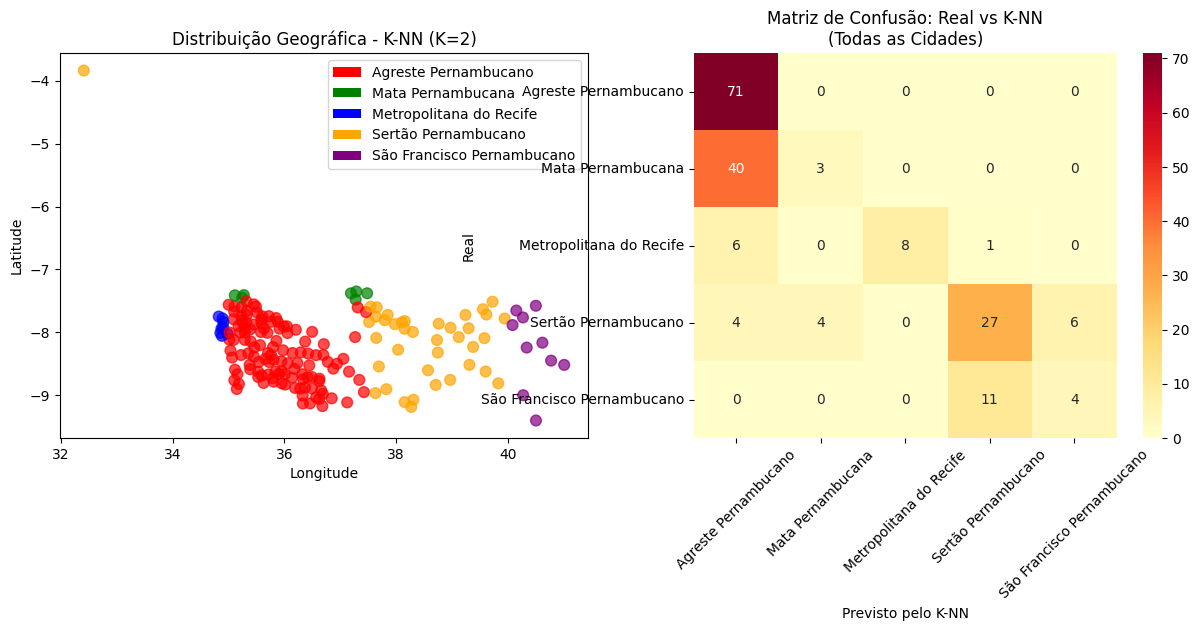

In [104]:
plt.figure(figsize=(15, 5))

# Plot 1: Distribuição geográfica das previsões do K-NN
plt.subplot(1, 2, 1)
cores_mesorregioes = {
    'Agreste Pernambucano': 'red', 
    'Mata Pernambucana': 'green', 
    'Metropolitana do Recife': 'blue',
    'Sertão Pernambucano': 'orange', 
    'São Francisco Pernambucano': 'purple'
}

dados_plot_knn = dados_agregados.dropna(subset=['Predicao_KNN'])
cores_lista_knn = []
for predicao in dados_plot_knn['Predicao_KNN']:
    cores_lista_knn.append(cores_mesorregioes.get(predicao, 'gray'))

plt.scatter(dados_plot_knn['Longitude'], dados_plot_knn['Latitude'], 
           c=cores_lista_knn, s=60, alpha=0.7)
plt.title(f'Distribuição Geográfica - K-NN (K={best_k})')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color, label=regiao) 
                   for regiao, color in cores_mesorregioes.items()]
plt.legend(handles=legend_elements, loc='best')

# Plot 2: Matriz de confusão K-NN (todas as cidades)
plt.subplot(1, 2, 2)
cross_tab_knn = pd.crosstab(dados_agregados['Target'], dados_agregados['Predicao_KNN'])
sns.heatmap(cross_tab_knn, annot=True, fmt='d', cmap='YlOrRd')
plt.title('Matriz de Confusão: Real vs K-NN\n(Todas as Cidades)')
plt.xlabel('Previsto pelo K-NN')
plt.ylabel('Real')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

plt.show()


In [105]:
for mesorregiao in sorted(dados_agregados['Predicao_KNN'].unique()):
    cidades_mesorregiao = dados_agregados[dados_agregados['Predicao_KNN'] == mesorregiao].index.tolist()
    print(f"--- {mesorregiao} ({len(cidades_mesorregiao)} cidades) ---")
    print(f"Cidades: {', '.join(sorted(cidades_mesorregiao))}")
    print()

--- Agreste Pernambucano (121 cidades) ---
Cidades: Agrestina, Alagoinha, Aliança, Altinho, Amaraji, Angelim, Araçoiaba, Arcoverde, Barra de Guabiraba, Barreiros, Belo Jardim, Belém de Maria, Bezerros, Bom Conselho, Bom Jardim, Bonito, Brejo da Madre de Deus, Brejão, Buenos Aires, Buíque, Cabo de Santo Agostinho, Cachoeirinha, Caetés, Calçado, Camocim de São Félix, Canhotinho, Capoeiras, Carpina, Caruaru, Casinhas, Catende, Chã Grande, Chã de Alegria, Condado, Correntes, Cortês, Cumaru, Cupira, Escada, Feira Nova, Frei Miguelinho, Gameleira, Garanhuns, Glória do Goitá, Goiana, Gravatá, Iati, Ibirajuba, Ingazeira, Ipojuca, Itaquitinga, Itaíba, Jaboatão dos Guararapes, Jaqueira, Jataúba, Joaquim Nabuco, João Alfredo, Jucati, Jupi, Jurema, Lagoa de Itaenga, Lagoa do Carro, Lagoa do Ouro, Lagoa dos Gatos, Lajedo, Limoeiro, Macaparana, Machados, Maraial, Moreno, Nazaré da Mata, Orobó, Palmares, Palmeirina, Panelas, Paranatama, Passira, Paudalho, Pedra, Pesqueira, Pombos, Poção, Primavera, Q